# Optimize a black-box protein sequence-function analyzer

In [1]:
# this jupyter notebook is running inside of the "notebooks" directory
# for relative paths to work properly, we need to set the current working directory to the root of the project
# for imports to work properly, we need to add the code folder to the system path
import os
from os.path import abspath, join, isdir
import sys
if not isdir("notebooks"):
    # if there's a "notebooks" directory in the cwd, we've already set the cwd so no need to do it again
    os.chdir("..")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import seaborn as sns
import sys

import design_tools
import constants
import encode as enc
import inference as inf

## Define variables for protein

In [3]:
WT = 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
AAs = constants.CHARS

# List of lists: possible amino acids at each position, default is every AA for each position (includes WT AAs)
AA_options = [tuple([AA for AA in AAs]) for i in range(len(WT))]
AA_options.pop(0)
AA_options.insert(0, ['M'])

## Define black-box seq2fitness analyzers

In [4]:
model_dir = "pub/trained_models/gb1/"
lr_prefix = model_dir + "gb1_lr"
fc_prefix = model_dir + "gb1_fc"
cnn_prefix = model_dir + "gb1_cnn"
gcn_prefix = model_dir + "gb1_gcn"

lr_sess = inf.restore_sess(lr_prefix)
fc_sess = inf.restore_sess(fc_prefix)
cnn_sess = inf.restore_sess(cnn_prefix)
gcn_sess = inf.restore_sess(gcn_prefix)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from pub/trained_models/gb1/gb1_lr
INFO:tensorflow:Restoring parameters from pub/trained_models/gb1/gb1_fc
INFO:tensorflow:Restoring parameters from pub/trained_models/gb1/gb1_cnn
INFO:tensorflow:Restoring parameters from pub/trained_models/gb1/gb1_gcn


In [5]:
# Function that given a sequence returns its predicted functional score
def seq2fitness(sequence):
    encoded_seq = enc.encode(encoding="one_hot,aa_index", char_seqs=[sequence])
    function_lr = inf.run_inference(encoded_data=encoded_seq, sess=lr_sess)
    function_fc	= inf.run_inference(encoded_data=encoded_seq, sess=fc_sess)
    function_gcn = inf.run_inference(encoded_data=encoded_seq, sess=gcn_sess)
    function_cnn = inf.run_inference(encoded_data=encoded_seq, sess=cnn_sess)
    return min([function_lr, function_fc, function_gcn, function_cnn])

# Test:
print(seq2fitness(WT))

-2.4499362


In [6]:
# Function that given a list of sequences returns a list of their predicted functional scores
# Using seq2fitness_many can often help speed up hill climbing process
def seq2fitness_many(sequences):
    encoded_many_variants = enc.encode(encoding="one_hot,aa_index", char_seqs=sequences)
    functions_lr = inf.run_inference(encoded_data=encoded_many_variants, sess=lr_sess)
    functions_fc = inf.run_inference(encoded_data=encoded_many_variants, sess=fc_sess)
    functions_cnn = inf.run_inference(encoded_data=encoded_many_variants, sess=cnn_sess)
    functions_gcn = inf.run_inference(encoded_data=encoded_many_variants, sess=gcn_sess)
    return [min(functions) for functions in zip(functions_lr, functions_fc, functions_cnn, functions_gcn)]

# Test:
print(seq2fitness_many([WT] * 10))

[-2.4499362, -2.4499362, -2.4499362, -2.4499362, -2.4499362, -2.4499362, -2.4499362, -2.4499362, -2.4499362, -2.4499362]


## Define hill climbing parameters

In [7]:
num_mut = 10 # number of mutations to introduce
num_restarts = 1 # number of random initializations of hill-climbing
max_steps = 1000 # maximum iterations for searching+climbing the hill
mut_rate = 1 # how many mutations to introduce during each round of searching

## Run hill climbing

Beginning restart 0


100%|██████████| 172/172 [00:50<00:00,  3.42it/s]


Current fitness: -0.2208


100%|██████████| 172/172 [00:56<00:00,  3.05it/s]


Current fitness: 2.3709


100%|██████████| 172/172 [01:01<00:00,  2.80it/s]


Current fitness: 3.9525


100%|██████████| 172/172 [00:55<00:00,  3.12it/s]


Current fitness: 5.0985


100%|██████████| 172/172 [01:05<00:00,  2.63it/s]


Current fitness: 5.6982


100%|██████████| 172/172 [00:59<00:00,  2.88it/s]


Current fitness: 6.1668


100%|██████████| 172/172 [01:01<00:00,  2.78it/s]


Current fitness: 6.2515


100%|██████████| 172/172 [01:13<00:00,  2.33it/s]


Current fitness: 6.7588


100%|██████████| 172/172 [01:13<00:00,  2.33it/s]


Current fitness: 7.2099


100%|██████████| 172/172 [02:25<00:00,  1.18it/s]


Current fitness: 7.2978


100%|██████████| 172/172 [02:44<00:00,  1.05it/s]


Current fitness: 7.6715


100%|██████████| 172/172 [01:28<00:00,  1.95it/s]


Current fitness: 7.8358


100%|██████████| 172/172 [01:00<00:00,  2.86it/s]


Current fitness: 8.0878


100%|██████████| 172/172 [01:04<00:00,  2.68it/s]


Current fitness: 8.0878


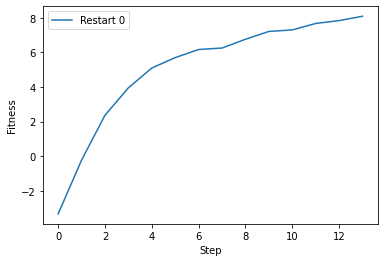

T15I,A33M,D39W,L6S,Y32A,V28K,D46R,T10W,G8W,A23P
8.087834358215332


In [8]:
hill_climber = design_tools.Hill_climber(seq2fitness, WT, AA_options, num_mut, mut_rate=mut_rate, 
                                  num_restarts=num_restarts, max_steps=max_steps)
hill_climber.seq2fitness_many = seq2fitness_many
best_mut, fitness = hill_climber.optimize()
hill_climber.plot_trajectory()
with open('output/designs/best_mut_hill_climbing_nmut_{}_restart_{}.pkl'.format(num_mut, 0), 'wb') as f:
    pickle.dump([best_mut, float(fitness)], f)

print(best_mut)
print(fitness)

## Analysis of designs

In [11]:
# No random restarts, hill climbing reaches a local optima
directory = 'output/designs'
designs = []
fitnesses = []
for file_name in fnmatch.filter(os.listdir(directory), 'best_mut_hill_climbing_nmut_*'):
    print(file_name)
    with open(join(directory, file_name), 'rb') as f:
        best_mut, fitness = pickle.load(f)
    designs.append(best_mut)
    fitnesses.append(fitness)
    
print('Max fitness for {} mutations is {} with mutations {}'.format(num_mut, round(max(fitnesses), 4), designs[fitnesses.index(max(fitnesses))]))

best_mut_hill_climbing_nmut_10_restart_0.pkl
Max fitness for 10 mutations is 8.0878 with mutations T15I,A33M,D39W,L6S,Y32A,V28K,D46R,T10W,G8W,A23P


### Analysis of 100 designed 10 mutants

In [12]:
# Determine 10 mutant designs from 10 random restarts each
directory = 'output/designs/10_mutant_designs'
all_mutation_sets = []
all_fitnesses = []
for file_name in fnmatch.filter(os.listdir(directory), 'best_mut_hill_climbing_nmut_*'):
    with open(join(directory, file_name), 'rb') as f:
        best_mut, fitness = pickle.load(f)
    all_mutation_sets.append(best_mut)
    all_fitnesses.append(fitness)
    
designs = []
fitnesses = []
for i in range(100):
    mutation_set = all_mutation_sets[i*10:i*10+10]
    fitness_set = all_fitnesses[i*10:i*10+10]
    designs.append(mutation_set[fitness_set.index(max(fitness_set))])
    fitnesses.append(max(fitness_set))

Number of unique designs: 73
Number of designs identical to Design10: 4
Max predicted fitness: 9.0


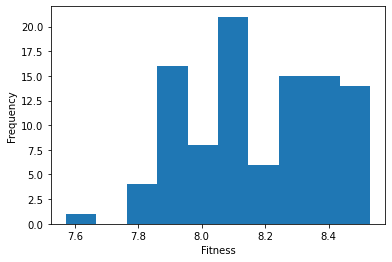

Mut: A23Y, Frequency: 0.93, In Design10? True
Mut: D39W, Frequency: 0.52, In Design10? True
Mut: D39Y, Frequency: 0.48, In Design10? False
Mut: V28K, Frequency: 0.48, In Design10? True
Mut: Q31L, Frequency: 0.45, In Design10? True
Mut: E41Q, Frequency: 0.42, In Design10? False
Mut: A33M, Frequency: 0.33, In Design10? False
Mut: N36I, Frequency: 0.32, In Design10? False
Mut: L6P, Frequency: 0.3, In Design10? False
Mut: T24R, Frequency: 0.24, In Design10? True
Mut: A22P, Frequency: 0.24, In Design10? True
Mut: Y44W, Frequency: 0.2, In Design10? False
Mut: Y32K, Frequency: 0.2, In Design10? False
Mut: D46R, Frequency: 0.18, In Design10? False
Mut: T15I, Frequency: 0.18, In Design10? False
Mut: D46W, Frequency: 0.17, In Design10? False
Mut: V28R, Frequency: 0.17, In Design10? False
Mut: E18W, Frequency: 0.16, In Design10? True
Mut: K49G, Frequency: 0.16, In Design10? False
Mut: T15L, Frequency: 0.15, In Design10? False
Mut: T15R, Frequency: 0.13, In Design10? False
Mut: E41T, Frequency: 0.

In [13]:
# Design10 info
d10 = 'MQYKLILNGKTLKGETWTWGHDPYRAEKKFKLYANDNGVWGEWTYDDATKTFTVTE'
d10_mutations = [wt_AA + str(i) + d10_AA for i, wt_AA, d10_AA in zip(range(len(WT)), WT, d10) if wt_AA != d10_AA]

# General statistics
designs_AA_seqs = [design_tools.mut2seq(WT, design) for design in designs]
print('Number of unique designs: {}'.format(len(set(designs_AA_seqs))))
print('Number of designs identical to Design10: {}'.format(designs_AA_seqs.count(d10)))
print('Max predicted fitness: {}'.format(round(max(fitnesses)), 3))

# Histogram of design fitnesses
plt.hist(fitnesses)
plt.xlabel('Fitness')
plt.ylabel('Frequency')
plt.show()

# Frequency of each mutation among 100 designs
all_mutations = []
for design in designs:
    for mut in design.split(','):
        if mut not in all_mutations:
            all_mutations.append(mut)
            
def frequency(mut):
    return round(','.join(designs).split(',').count(mut)/len(designs), 2)
all_mutations.sort(reverse=True, key=frequency)
for mut in all_mutations:
    if frequency(mut) < 0.1:
        break
    print('Mut: {}, Frequency: {}, In Design10? {}'.format(mut, frequency(mut), mut in d10_mutations))
